In [4]:
import shap
import scipy
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from sklearn.feature_selection import chi2, f_classif, f_regression, RFE
from sklearn.svm import SVR
from catboost import CatBoostRegressor, Pool

sns.set(
    { "figure.figsize": (17, 7) },
    style='ticks',
    palette=sns.color_palette("Set2"),
    color_codes=True,
    font_scale=5
)

plt.rcParams.update({
    "axes.labelsize": 12,  # Axes label font size
})

%config InlineBackend.figure_format = 'retina'
import warnings
warnings.filterwarnings('ignore')

In [5]:
# Load the dataset
auto = pd.read_csv('adverts.csv')

In [6]:
auto = auto.sample(50000)

In [5]:
mean_prices = []
for model in auto["standard_model"].unique():
    mean_prices.append([model, auto.loc[auto["standard_model"]==model, "price"].mean()])

In [6]:
model_prices_df = pd.DataFrame(mean_prices, columns=["model", "mean_price"])
model_prices_df

model    mean_price
0                Corsa  6.845875e+03
1              E Class  2.027269e+04
2             5 Series  1.838101e+04
3                T-Roc  2.380093e+04
4    Range Rover Velar  4.771115e+04
..                 ...           ...
804               TXII  3.000000e+03
805            Mondial  3.100000e+04
806              Combo  6.500000e+03
807               3500  9.999999e+06
808             LS 430  4.995000e+03

[809 rows x 2 columns]

In [7]:
auto = auto.dropna()

In [8]:
chi2(auto[["mileage", "year_of_registration", "public_reference", "price"]], auto["price"])

(array([6.21609399e+08, 2.49787245e+02, 1.31622273e+10, 1.68738877e+09]),
 array([0., 1., 0., 0.]))

In [9]:
f_classif(auto[["mileage", "year_of_registration", "public_reference", "price"]], auto["price"])

(array([4.53905082, 1.07481939, 1.42608405,        inf]),
 array([0.00000000e+00, 2.21286653e-05, 1.84350587e-95, 0.00000000e+00]))

In [10]:
f_regression(auto[["mileage", "year_of_registration", "public_reference", "price"]], auto["price"])

(array([ 3.30988477e+03,  5.37566549e+02,  2.00223142e+02, -3.38970932e+19]),
 array([0.00000000e+000, 3.13826380e-118, 2.33450312e-045, 1.00000000e+000]))

-6.4000689842427335e-06 4.306675216631101 0.3675539620788961 0.0 1.3828262003039064e-08


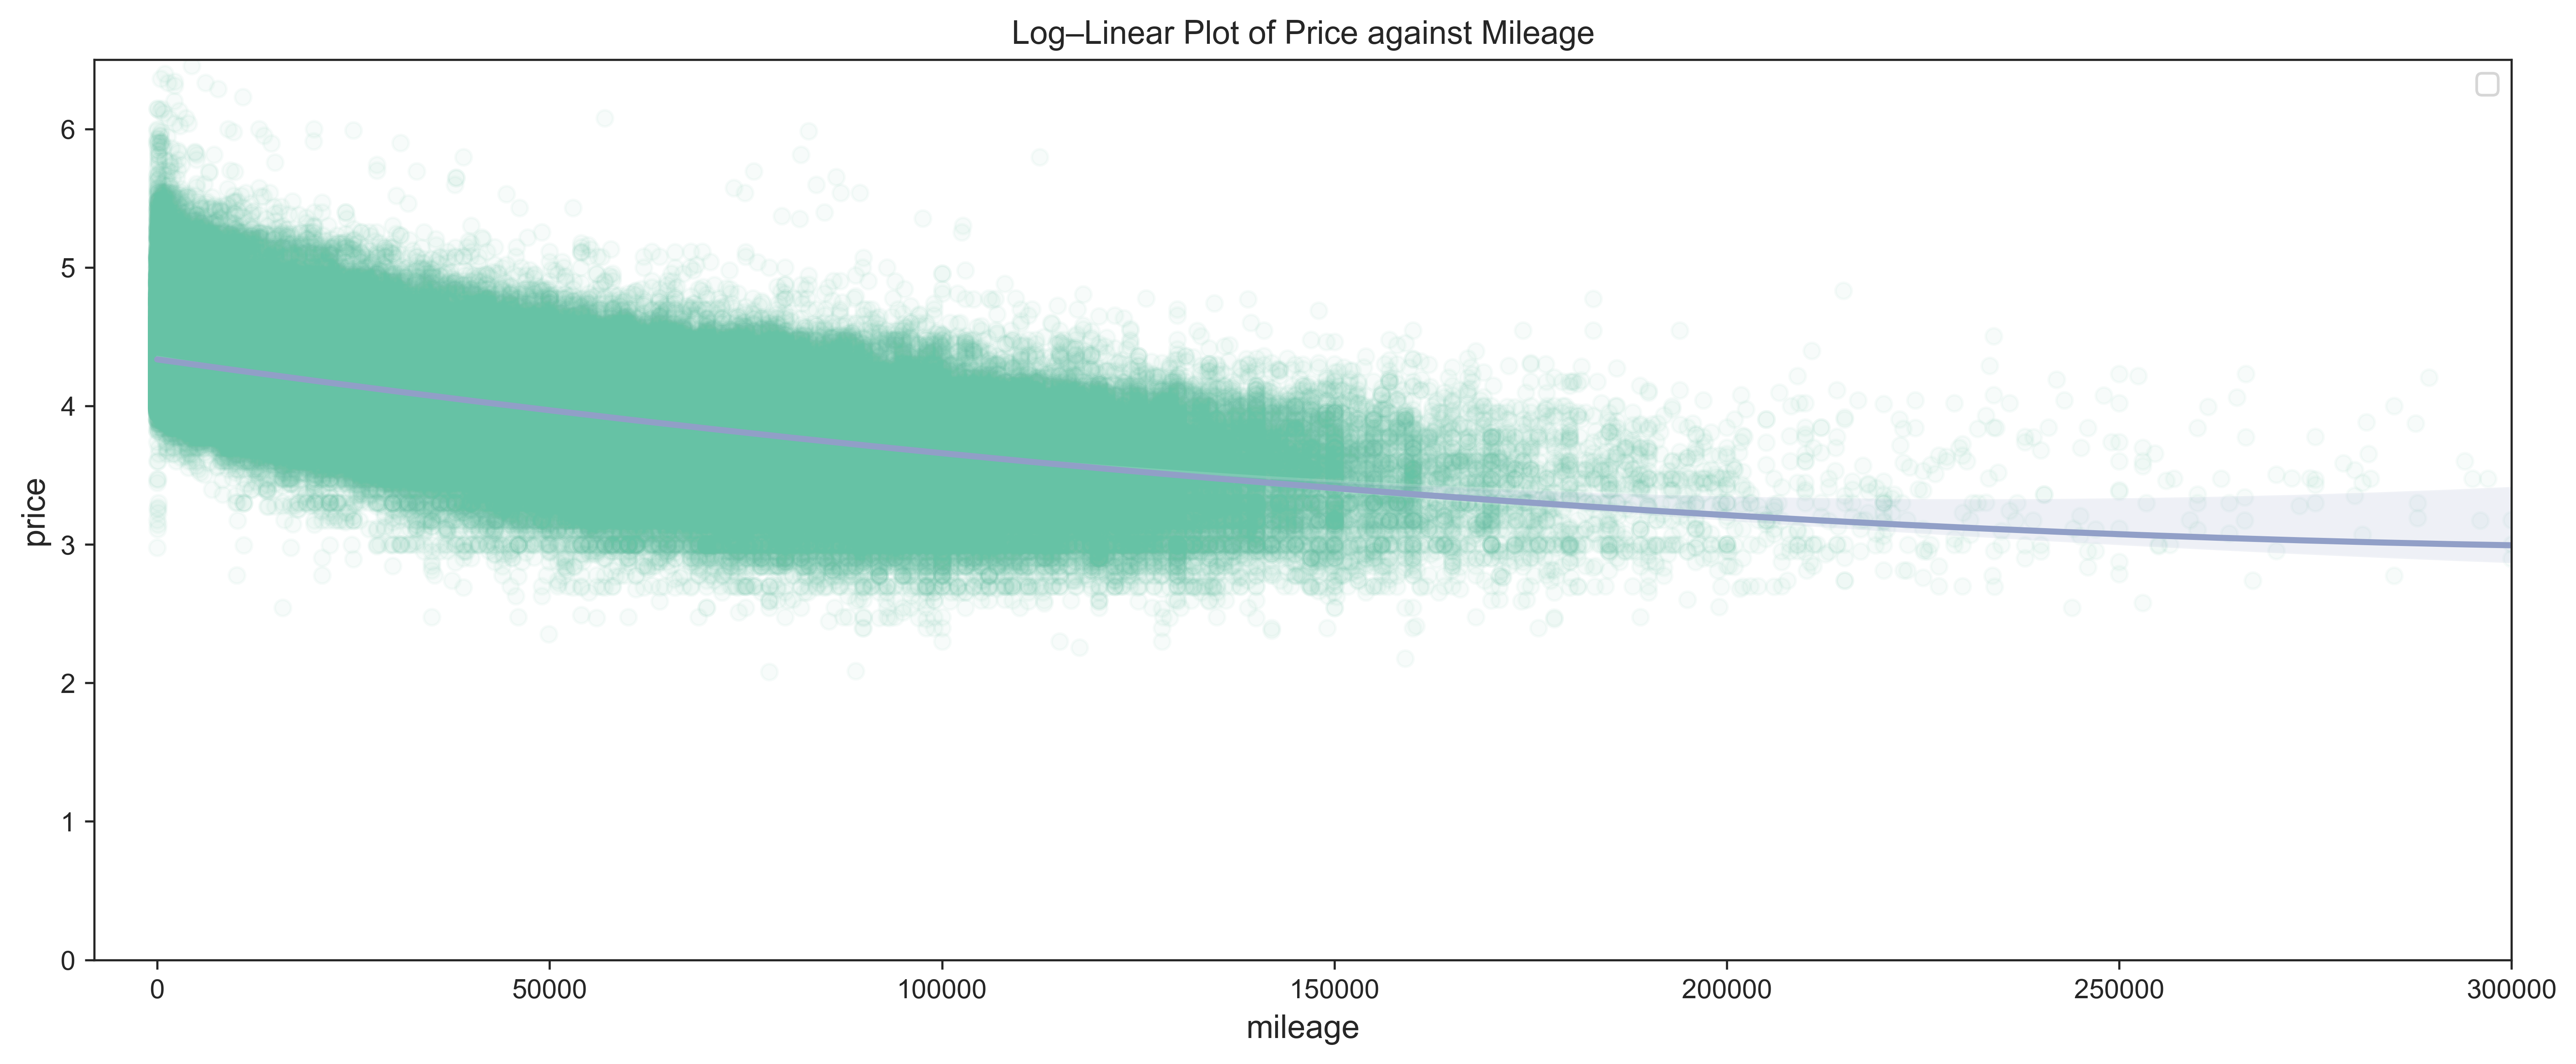

In [13]:
plt.figure(figsize=(16, 6), dpi=240)

ax = sns.regplot(auto, order=2, x="mileage", y="log_price", ci=99, scatter_kws={"alpha": 0.05}, line_kws={"color": "#919FC7"})

slope, intercept, r, p, sterr = scipy.stats.linregress(x=auto["mileage"],
                                                       y=auto["log_price"])
print(slope, intercept, r**2, p, sterr)

plt.title("Log–Linear Plot of Price against Mileage")
plt.xlabel('mileage')
plt.ylabel('price')
plt.ylim(0, 6.5)
plt.xlim(-8e3, 0.3e6)
plt.legend()

In [146]:
from scipy.optimize import curve_fit

def func(x, a, b):
    return a*10**(b*x)

popt, pcov = curve_fit(func, auto["mileage"], auto["price"], maxfev=3000, p0=[1000, -2])

popt

array([ 2.94651659e+04, -8.77352044e-06])

In [147]:
ys = func(auto["mileage"], *popt)

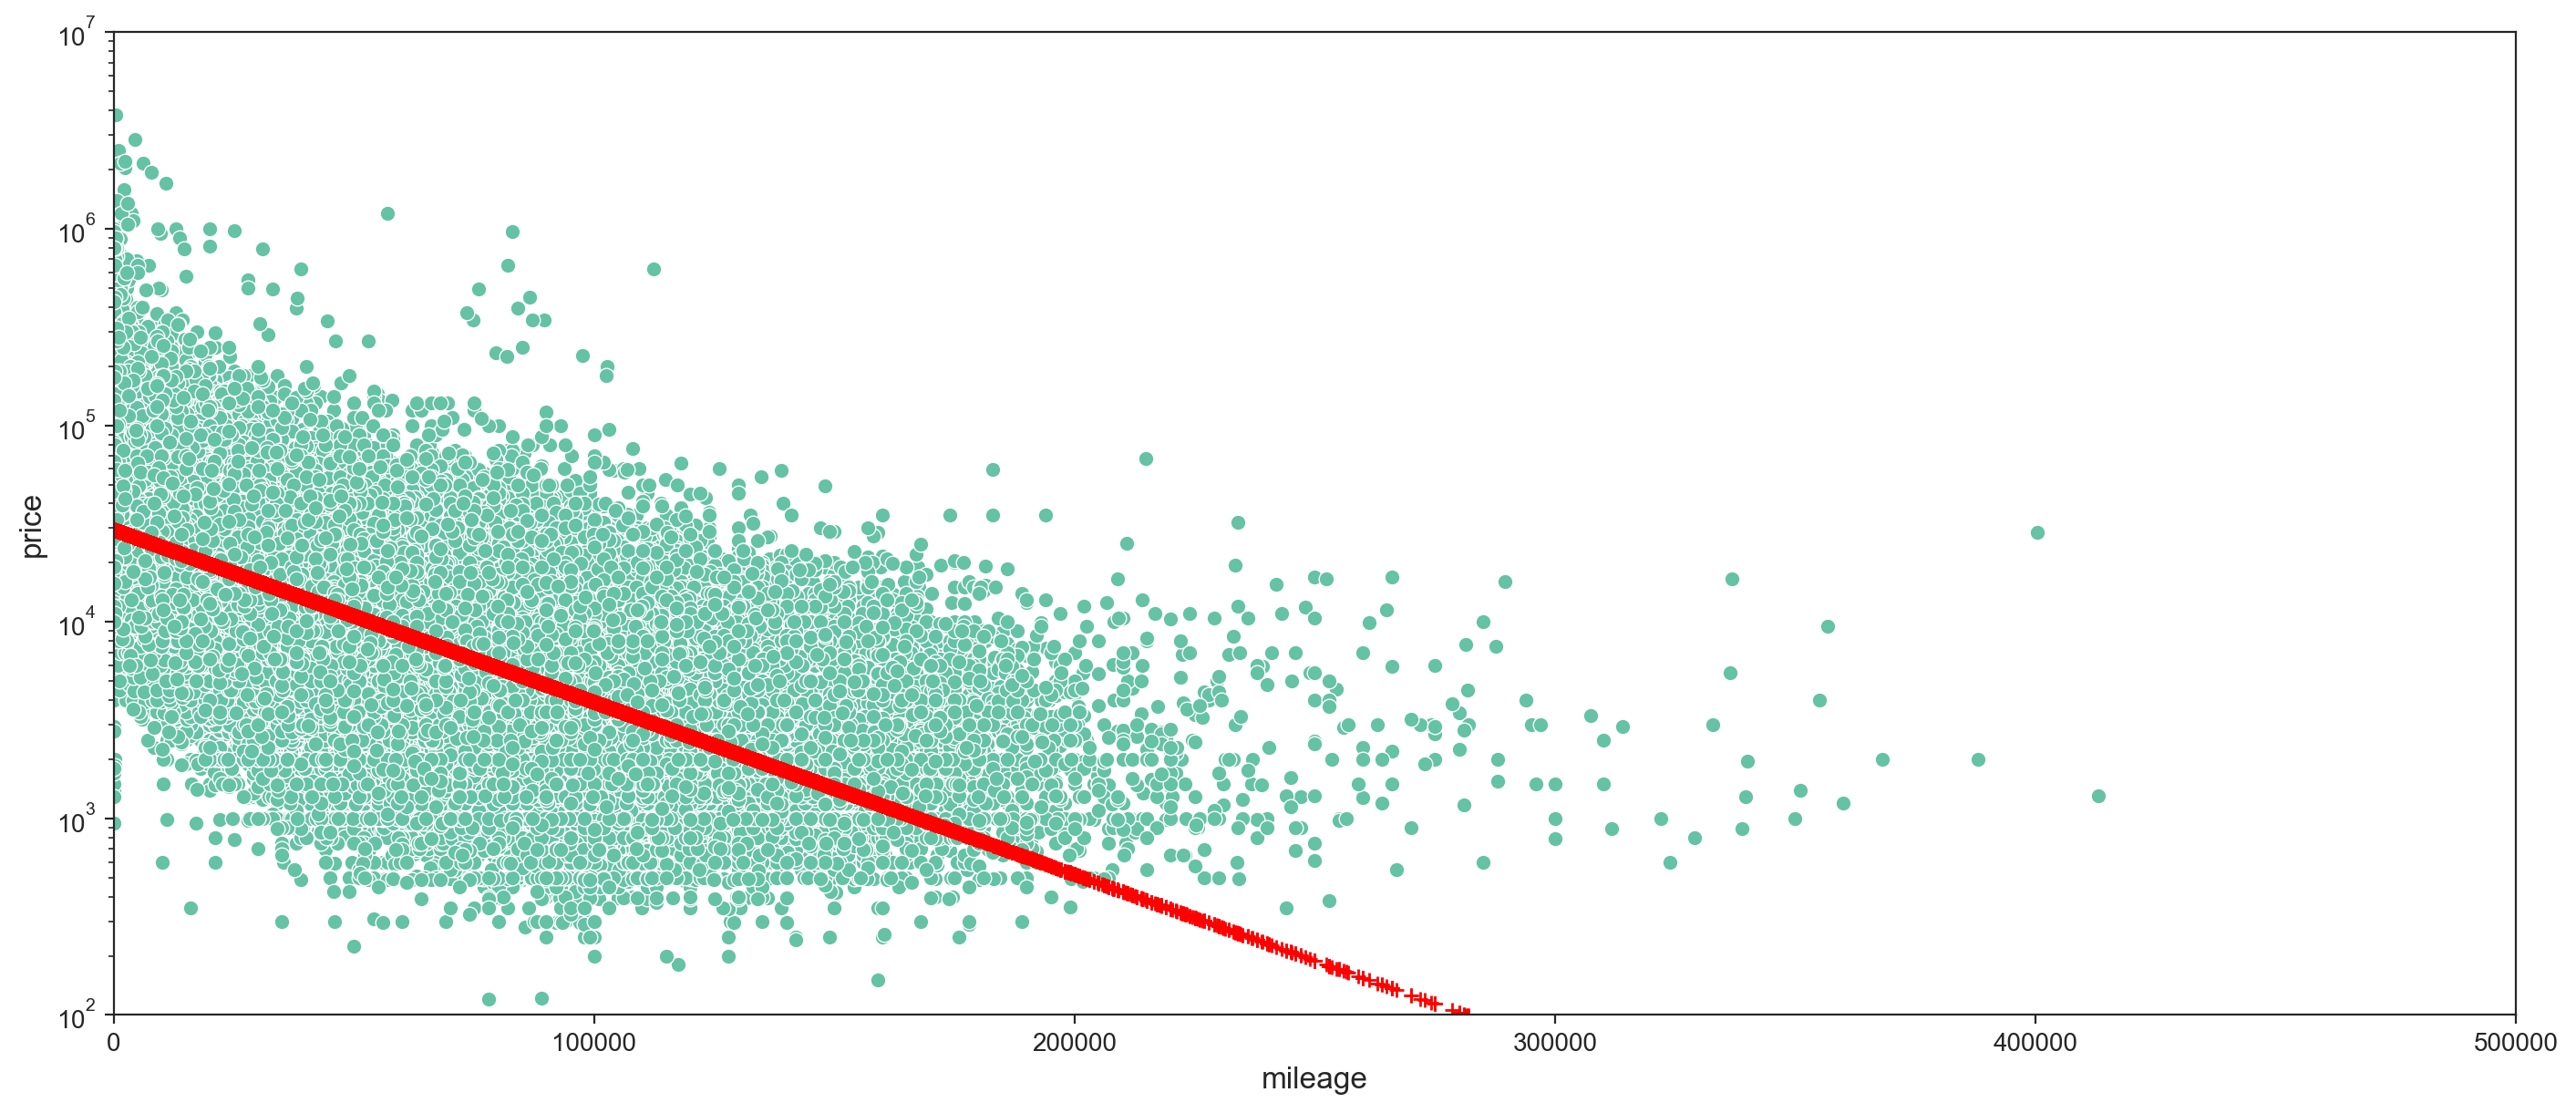

In [160]:
plt.plot(auto["mileage"], ys, "r+")
sns.scatterplot(auto, x="mileage", y="price")
plt.ylim(1e2, 1e7)
plt.xlim(0,5e5)
plt.yscale("log")

R-squared (log-space): 0.3675539620788969
mileage = 4.307 + -0.000 * log10(price)


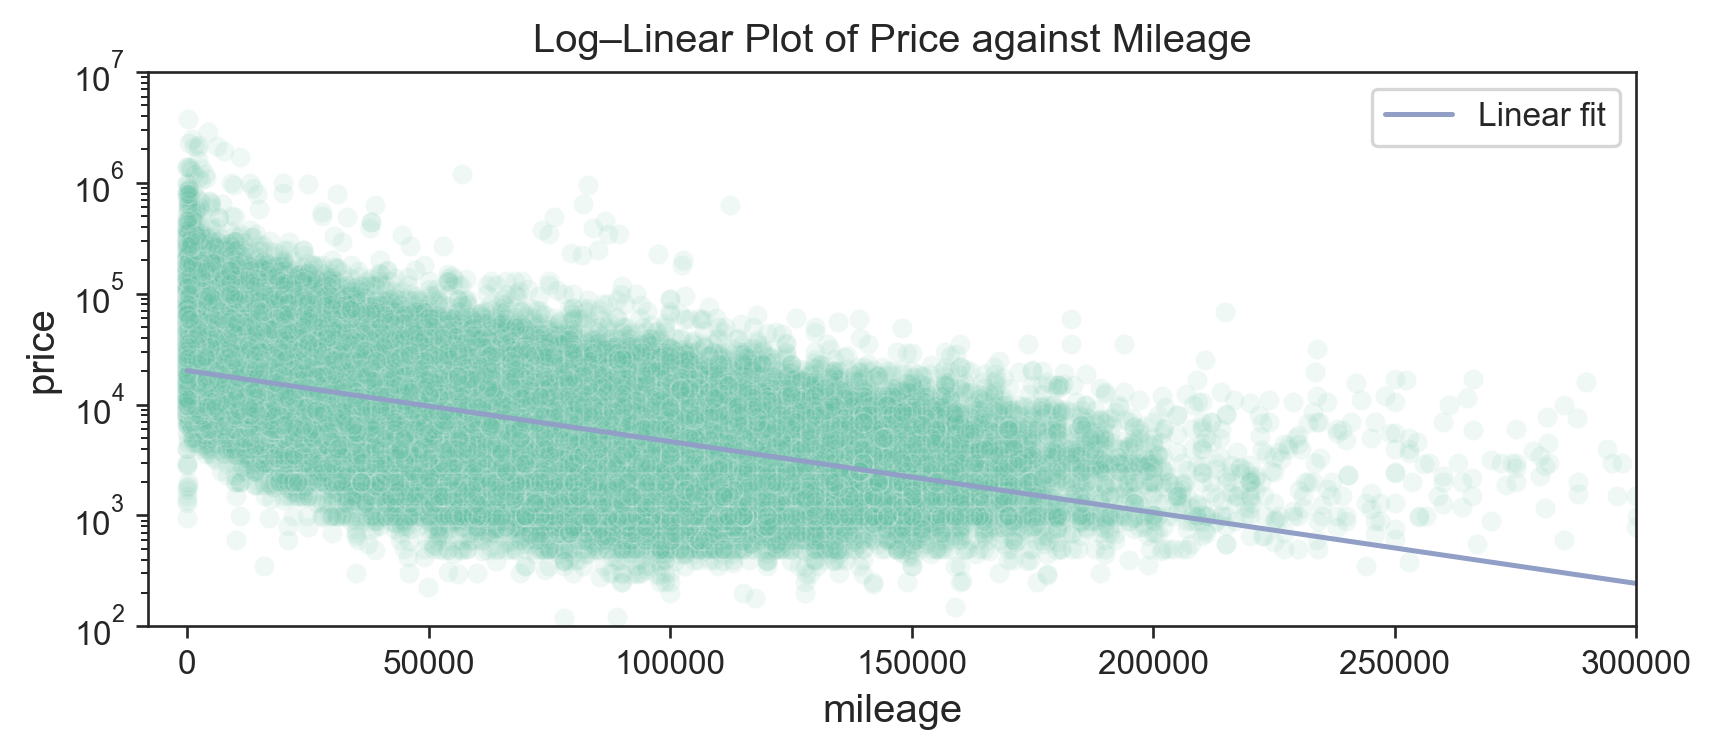

In [42]:
auto["log_price"] = np.log10(auto["price"])

X = sm.add_constant(auto['mileage'])
model = sm.OLS(auto['log_price'], X).fit()

intercept, slope = model.params['const'], model.params['mileage']

print("R-squared (log-space):", model.rsquared)
print(f"mileage = {intercept:.3f} + {slope:.3f} * log10(price)")

x_plot = np.linspace(auto['mileage'].min(), auto['mileage'].max(), 200)
y_hat = 10**intercept * x_plot**(slope)
X_pred = sm.add_constant(x_plot)

pred = model.get_prediction(X_pred)
log_y_hat = pred.summary_frame(alpha=0.01)['mean']

# Transform back to original space
y_hat = 10**log_y_hat

plt.figure(figsize=(8, 3), dpi=120)

sns.scatterplot(data=auto, y='price', x='mileage', alpha=0.1)
plt.plot(x_plot, y_hat, color="#919FC7", label='Linear fit')
plt.title("Log–Linear Plot of Price against Mileage")
plt.xlabel('mileage')
plt.ylabel('price')
plt.yscale("log")
plt.ylim(100, 1e7)
plt.xlim(-8e3, 0.3e6)
plt.legend()
plt.savefig("/Users/hal/Documents/Essays/AutoML/log_price_mileage.png", bbox_inches='tight', dpi=240)
plt.show()

In [30]:
split_year = 2002
auto_new = auto.loc[auto["year_of_registration"] >= split_year]
auto_old = auto.loc[auto["year_of_registration"] < split_year]

R-squared (log-space): 0.4963296930056632
year_of_registration = -300.370 + 0.154 * log(price)


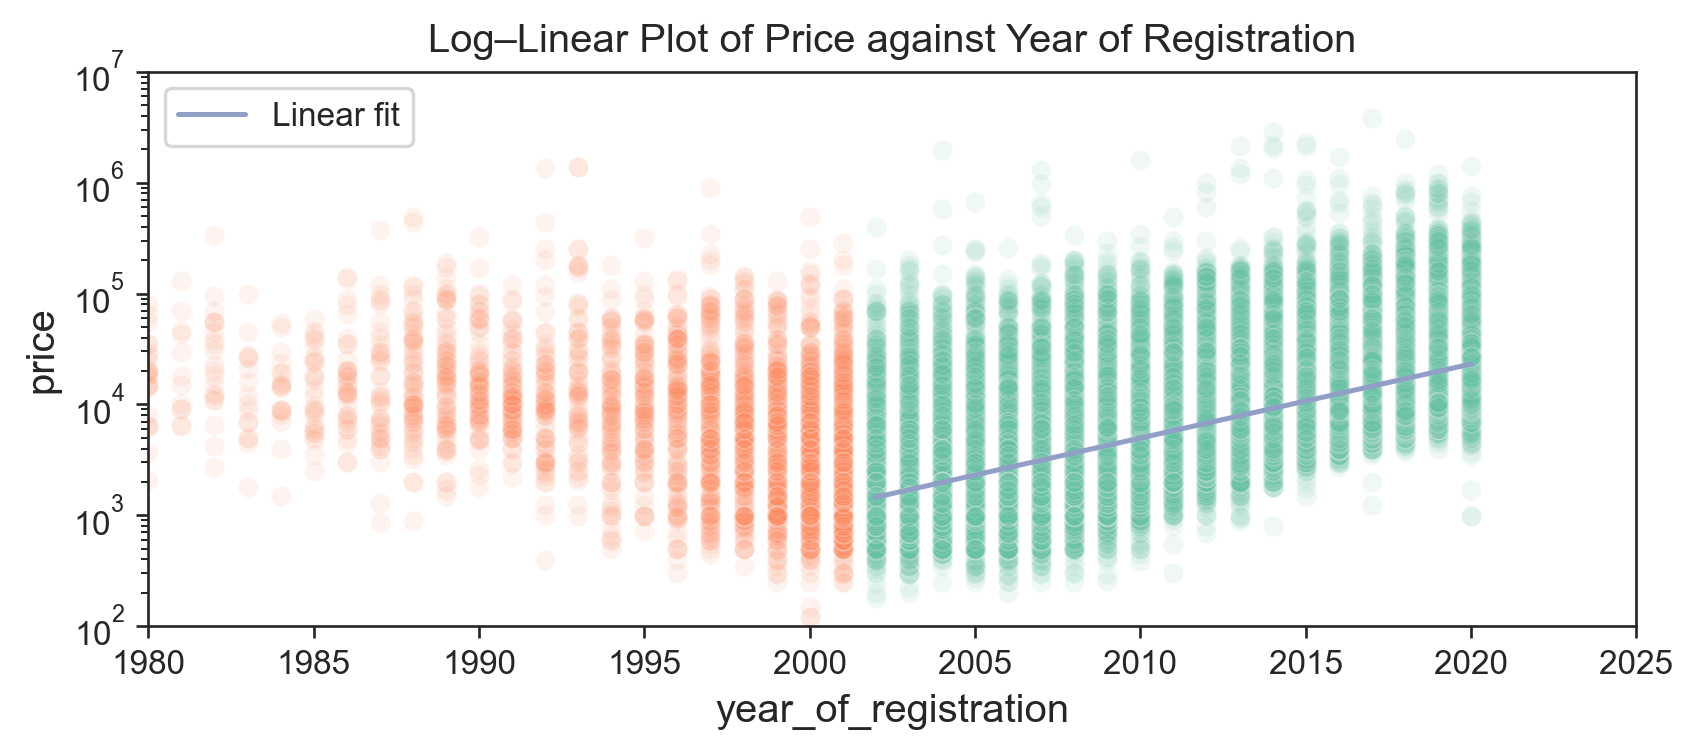

In [31]:
auto_new["log_price"] = np.log(auto_new["price"])

X = sm.add_constant(auto_new['year_of_registration'])  # Add intercept term
model = sm.OLS(auto_new['log_price'], X).fit()

intercept, slope = model.params['const'], model.params['year_of_registration']

print("R-squared (log-space):", model.rsquared)
print(f"year_of_registration = {intercept:.3f} + {slope:.3f} * log(price)")

x_plot = np.linspace(auto_new['year_of_registration'].min(), auto_new['year_of_registration'].max(), 200)
y_hat = np.exp(intercept) * x_plot**(slope)
X_pred = sm.add_constant(x_plot)

pred = model.get_prediction(X_pred)
summary_frame = pred.summary_frame(alpha=0.001)  # 99% CI

log_y_hat = summary_frame['mean']
log_ci_lower = summary_frame['mean_ci_lower']
log_ci_upper = summary_frame['mean_ci_upper']

# Transform back to original space
y_hat = np.exp(log_y_hat)
ci_lower = np.exp(log_ci_lower)
ci_upper = np.exp(log_ci_upper)

plt.figure(figsize=(8, 3), dpi=120)

sns.scatterplot(data=auto_new, y='price', x='year_of_registration', alpha=0.1)
sns.scatterplot(data=auto_old, y='price', x='year_of_registration', alpha=0.1)
plt.plot(x_plot, y_hat, color="#919FC7", label='Linear fit')
plt.title("Log–Linear Plot of Price against Year of Registration")
plt.xlabel('year_of_registration')
plt.ylabel('price')
plt.yscale("log")
plt.ylim(100, 1e7)
plt.xlim(1980, 2025)
plt.legend()
plt.savefig("/Users/hal/Documents/Essays/AutoML/log_price_year.png", bbox_inches='tight', dpi=240)
plt.show()

# SHAP

In [14]:
df = pd.read_csv("adverts.csv")
df = df.drop(columns=["reg_code", "standard_make"])
df = df.dropna()

In [15]:
for col in df:
    if isinstance(col, (str, bool)) and len(df[col].unique()) == 2:
        df[col] = df[col].replace({df[col].unique()[0]:0, df[col].unique()[1]:1})

df = df.convert_dtypes()

In [16]:
X, y = df.drop(columns="price"), df[["price"]]

cat_features = ['standard_colour', 'standard_model', 'vehicle_condition',
                 'body_type', 'crossover_car_and_van', 'fuel_type']

In [17]:
X_pool = Pool(X, cat_features=cat_features)

model = CatBoostRegressor()

model.fit(X, y, cat_features=cat_features)
print("Count of trees in model = {}".format(model.tree_count_))

Learning rate set to 0.103938
0:	learn: 22054.5831570	total: 133ms	remaining: 2m 12s
1:	learn: 21345.0537002	total: 179ms	remaining: 1m 29s
2:	learn: 20725.1066396	total: 233ms	remaining: 1m 17s
3:	learn: 20136.6264168	total: 281ms	remaining: 1m 9s
4:	learn: 19612.8837300	total: 325ms	remaining: 1m 4s
5:	learn: 19196.5916357	total: 371ms	remaining: 1m 1s
6:	learn: 18798.0329437	total: 440ms	remaining: 1m 2s
7:	learn: 18425.5099710	total: 486ms	remaining: 1m
8:	learn: 18194.2852084	total: 529ms	remaining: 58.2s
9:	learn: 17947.2610641	total: 575ms	remaining: 57s
10:	learn: 17748.8262080	total: 614ms	remaining: 55.2s
11:	learn: 17547.1156150	total: 686ms	remaining: 56.5s
12:	learn: 17389.6278737	total: 728ms	remaining: 55.3s
13:	learn: 17252.5669750	total: 777ms	remaining: 54.8s
14:	learn: 17151.9293628	total: 827ms	remaining: 54.3s
15:	learn: 17058.7577161	total: 888ms	remaining: 54.6s
16:	learn: 16882.7784182	total: 934ms	remaining: 54s
17:	learn: 16779.4355216	total: 984ms	remaining: 

In [18]:
importance = model.get_feature_importance(X_pool, type="ShapValues")

<Axes: xlabel='SHAP value (impact on model output)'>

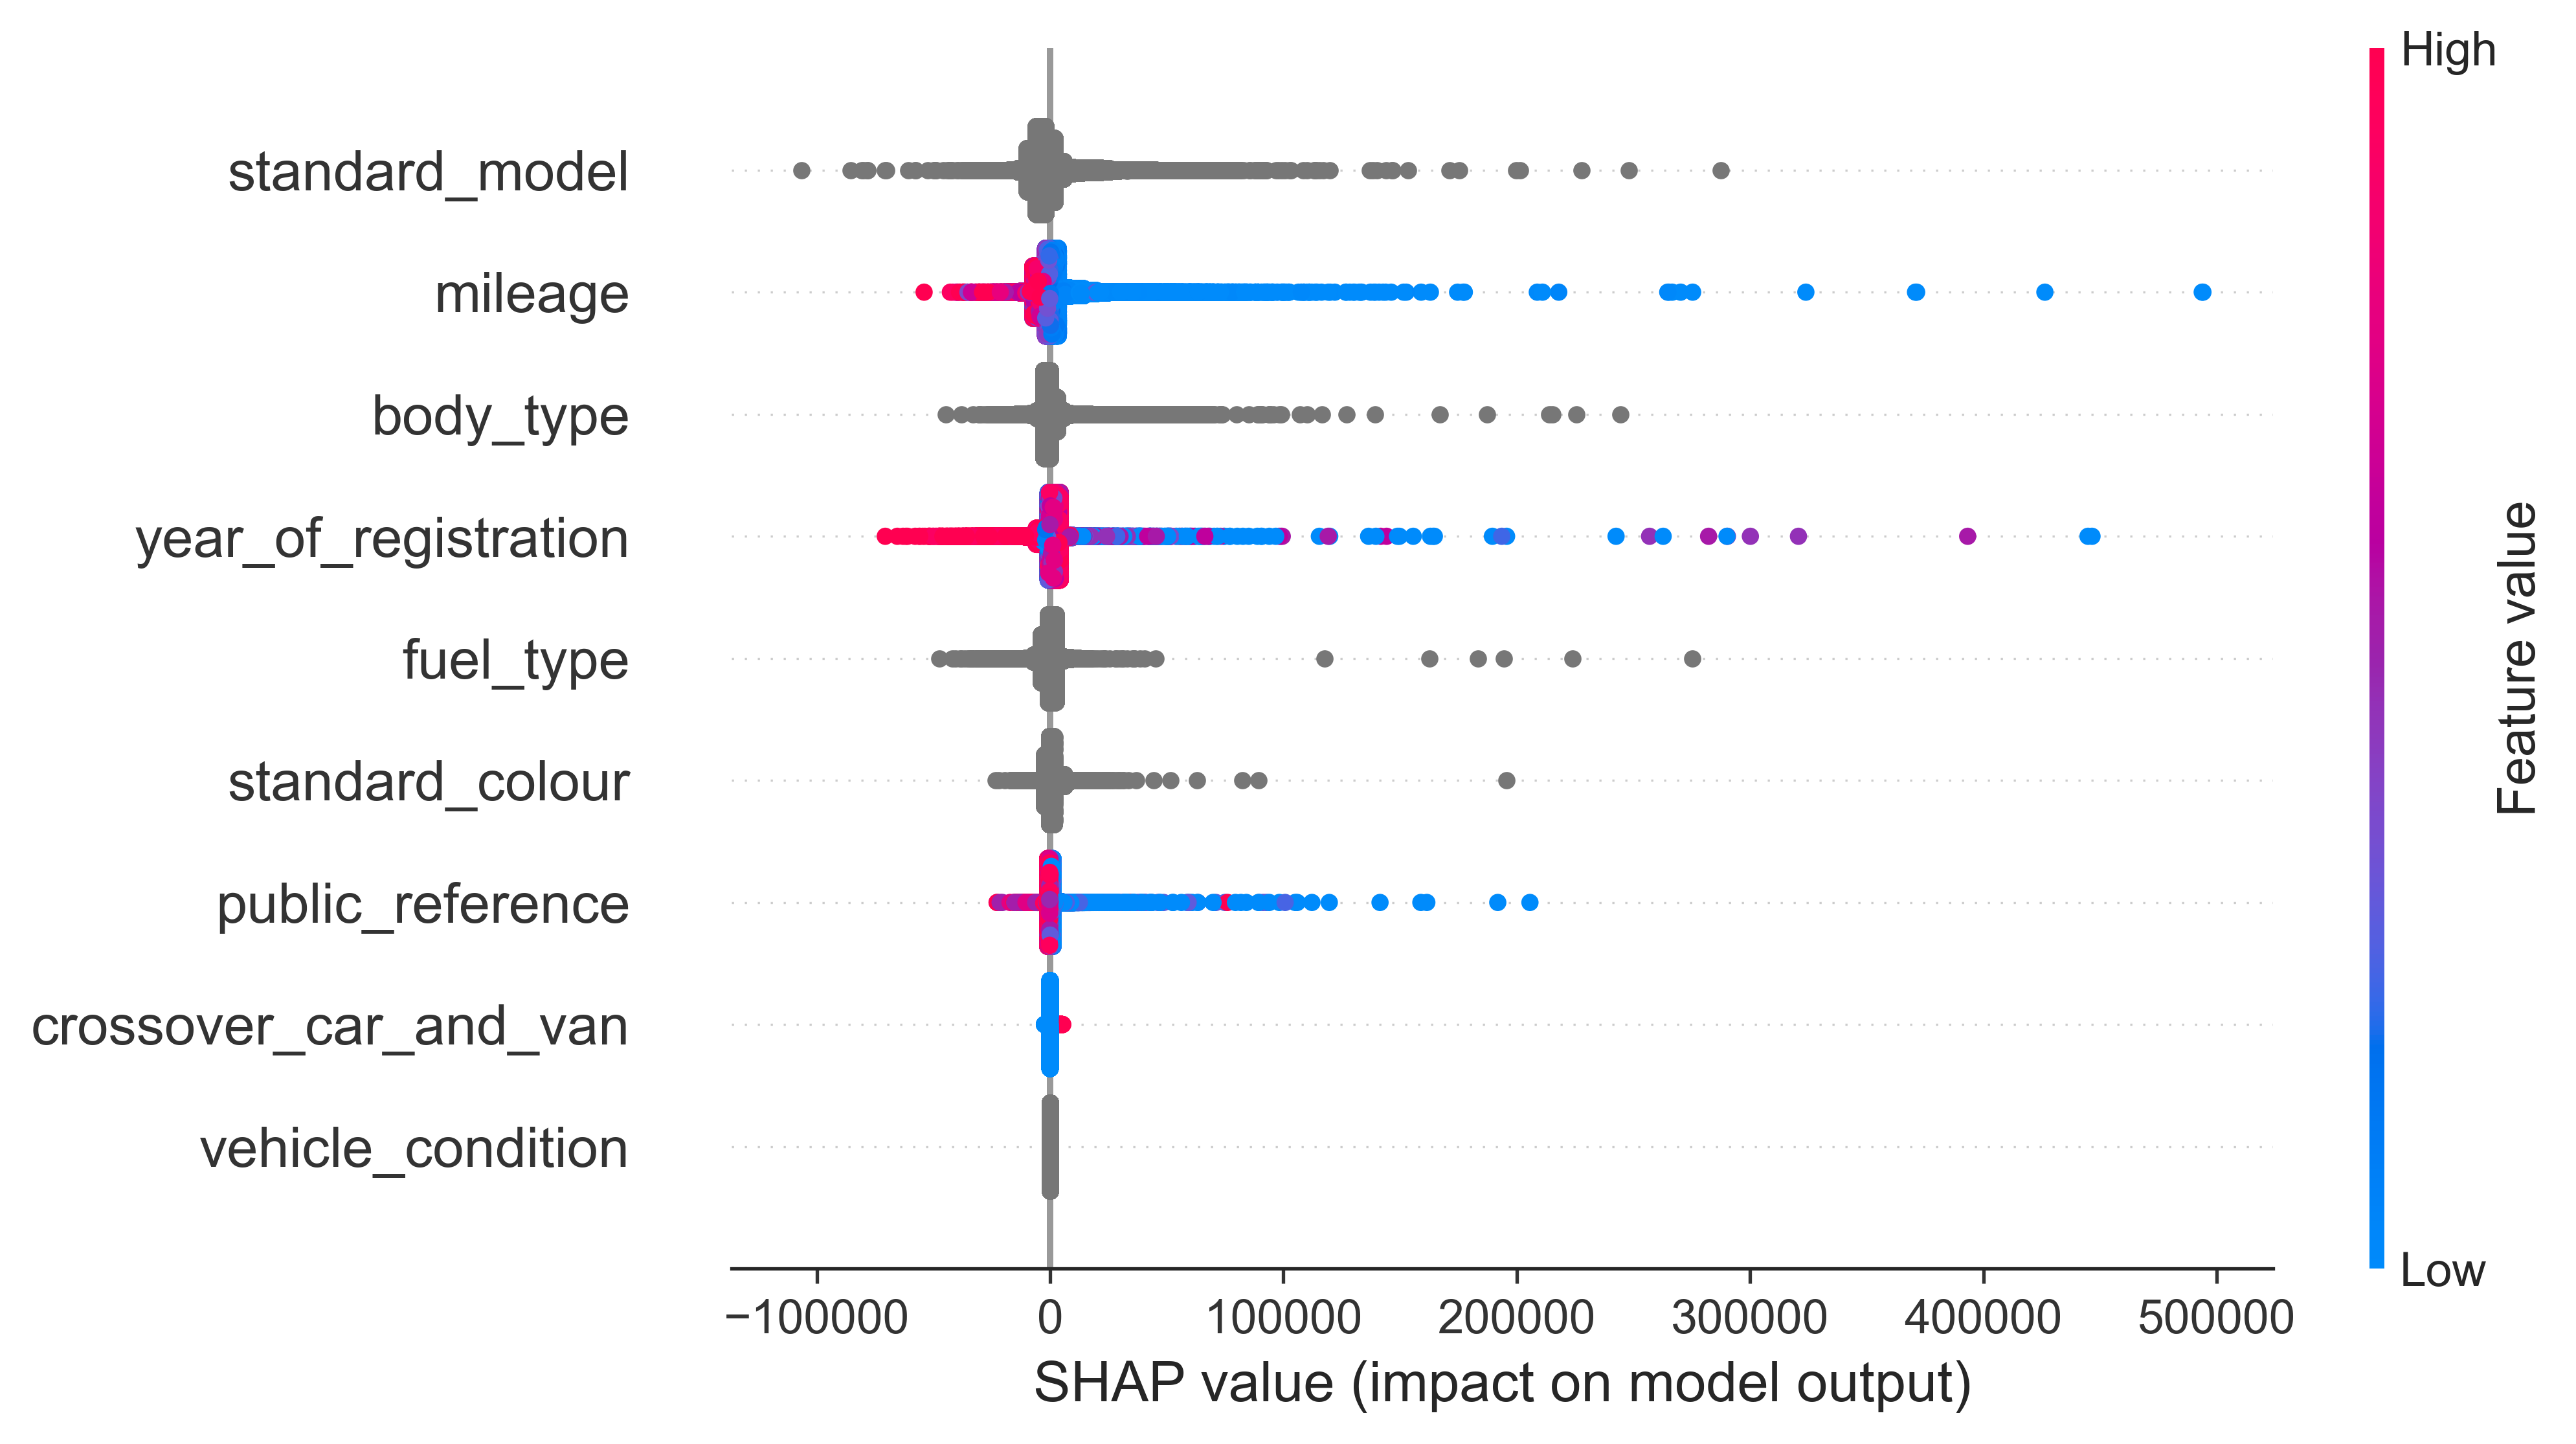

In [19]:
explainer = shap.Explainer(model)
shap_values = explainer(X)

# summarize the effects of all the features
plt.figure(figsize=(12, 5), dpi=240)
shap.plots.beeswarm(shap_values, show=False)

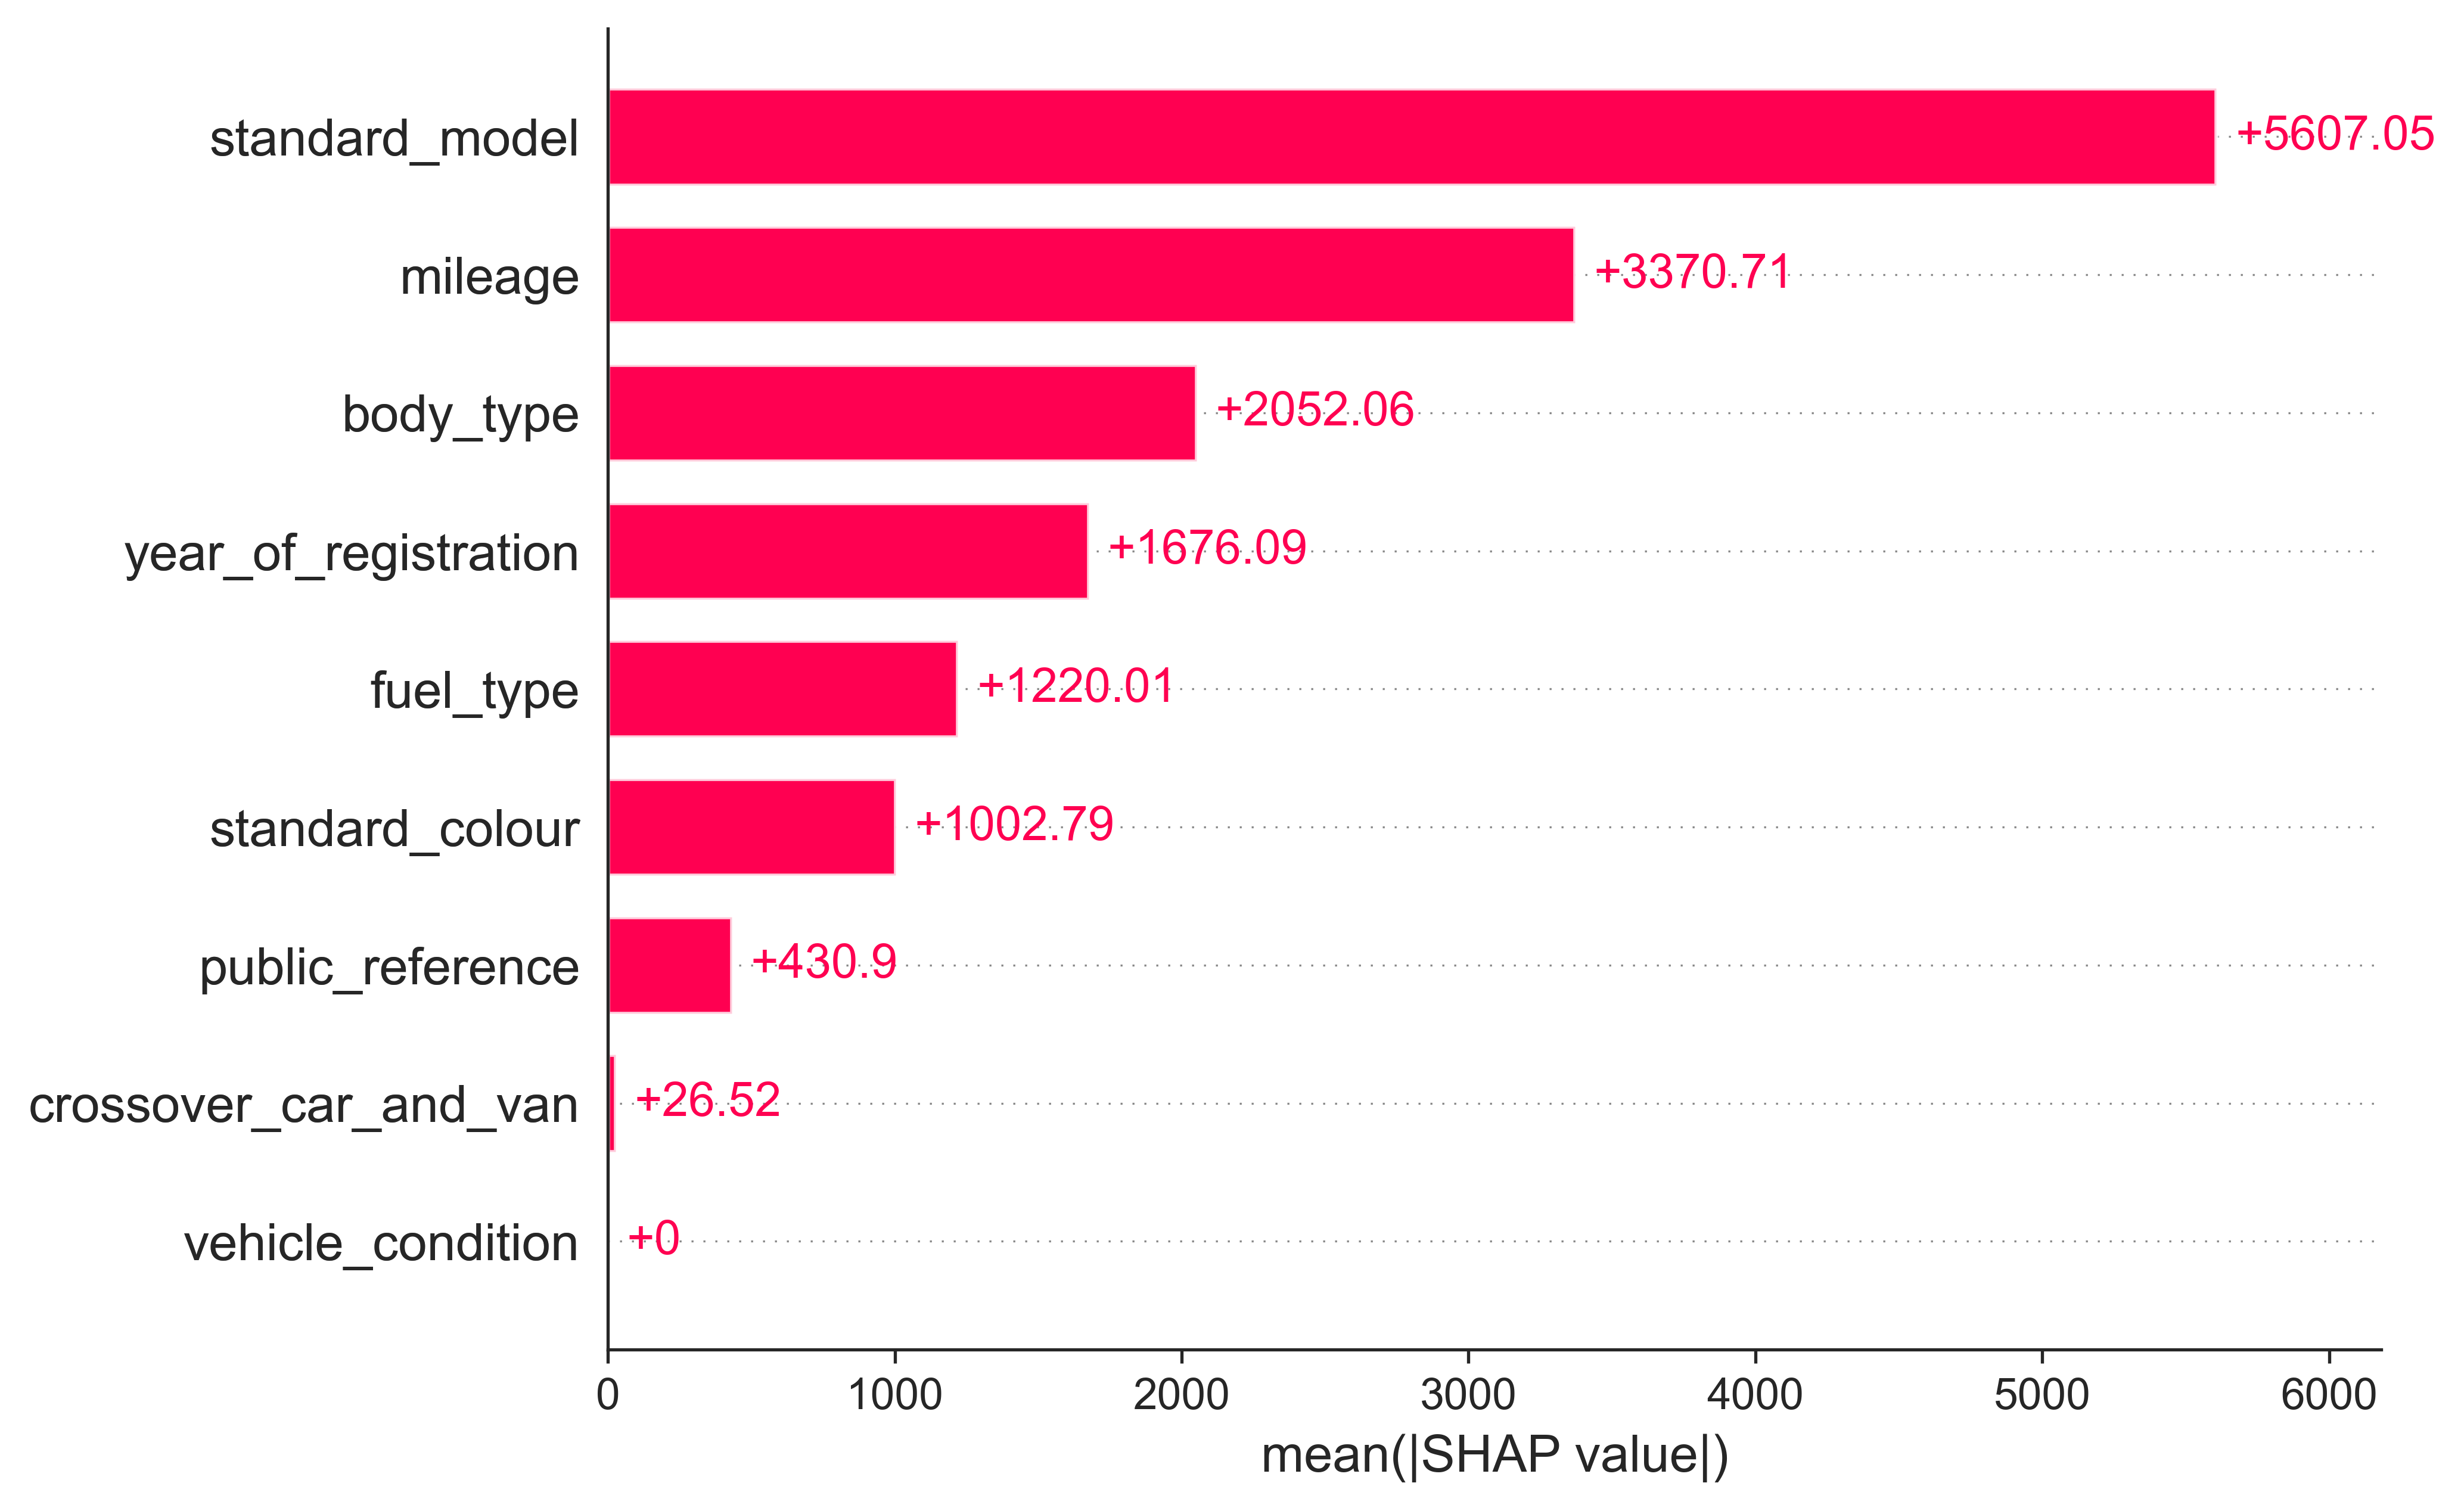

In [20]:
plt.figure(figsize=(12, 2), dpi=240)
shap.plots.bar(shap_values)

In [33]:
from sklearn.preprocessing import OrdinalEncoder
X = auto.drop(columns=["reg_code"])
X = X.replace({False:0,True:1,"USED":0,"NEW":1})
X = X.dropna()
X.convert_dtypes()
y = auto.loc[X.index, "price"]
X = pd.DataFrame(OrdinalEncoder().fit_transform(X), columns=X.columns)

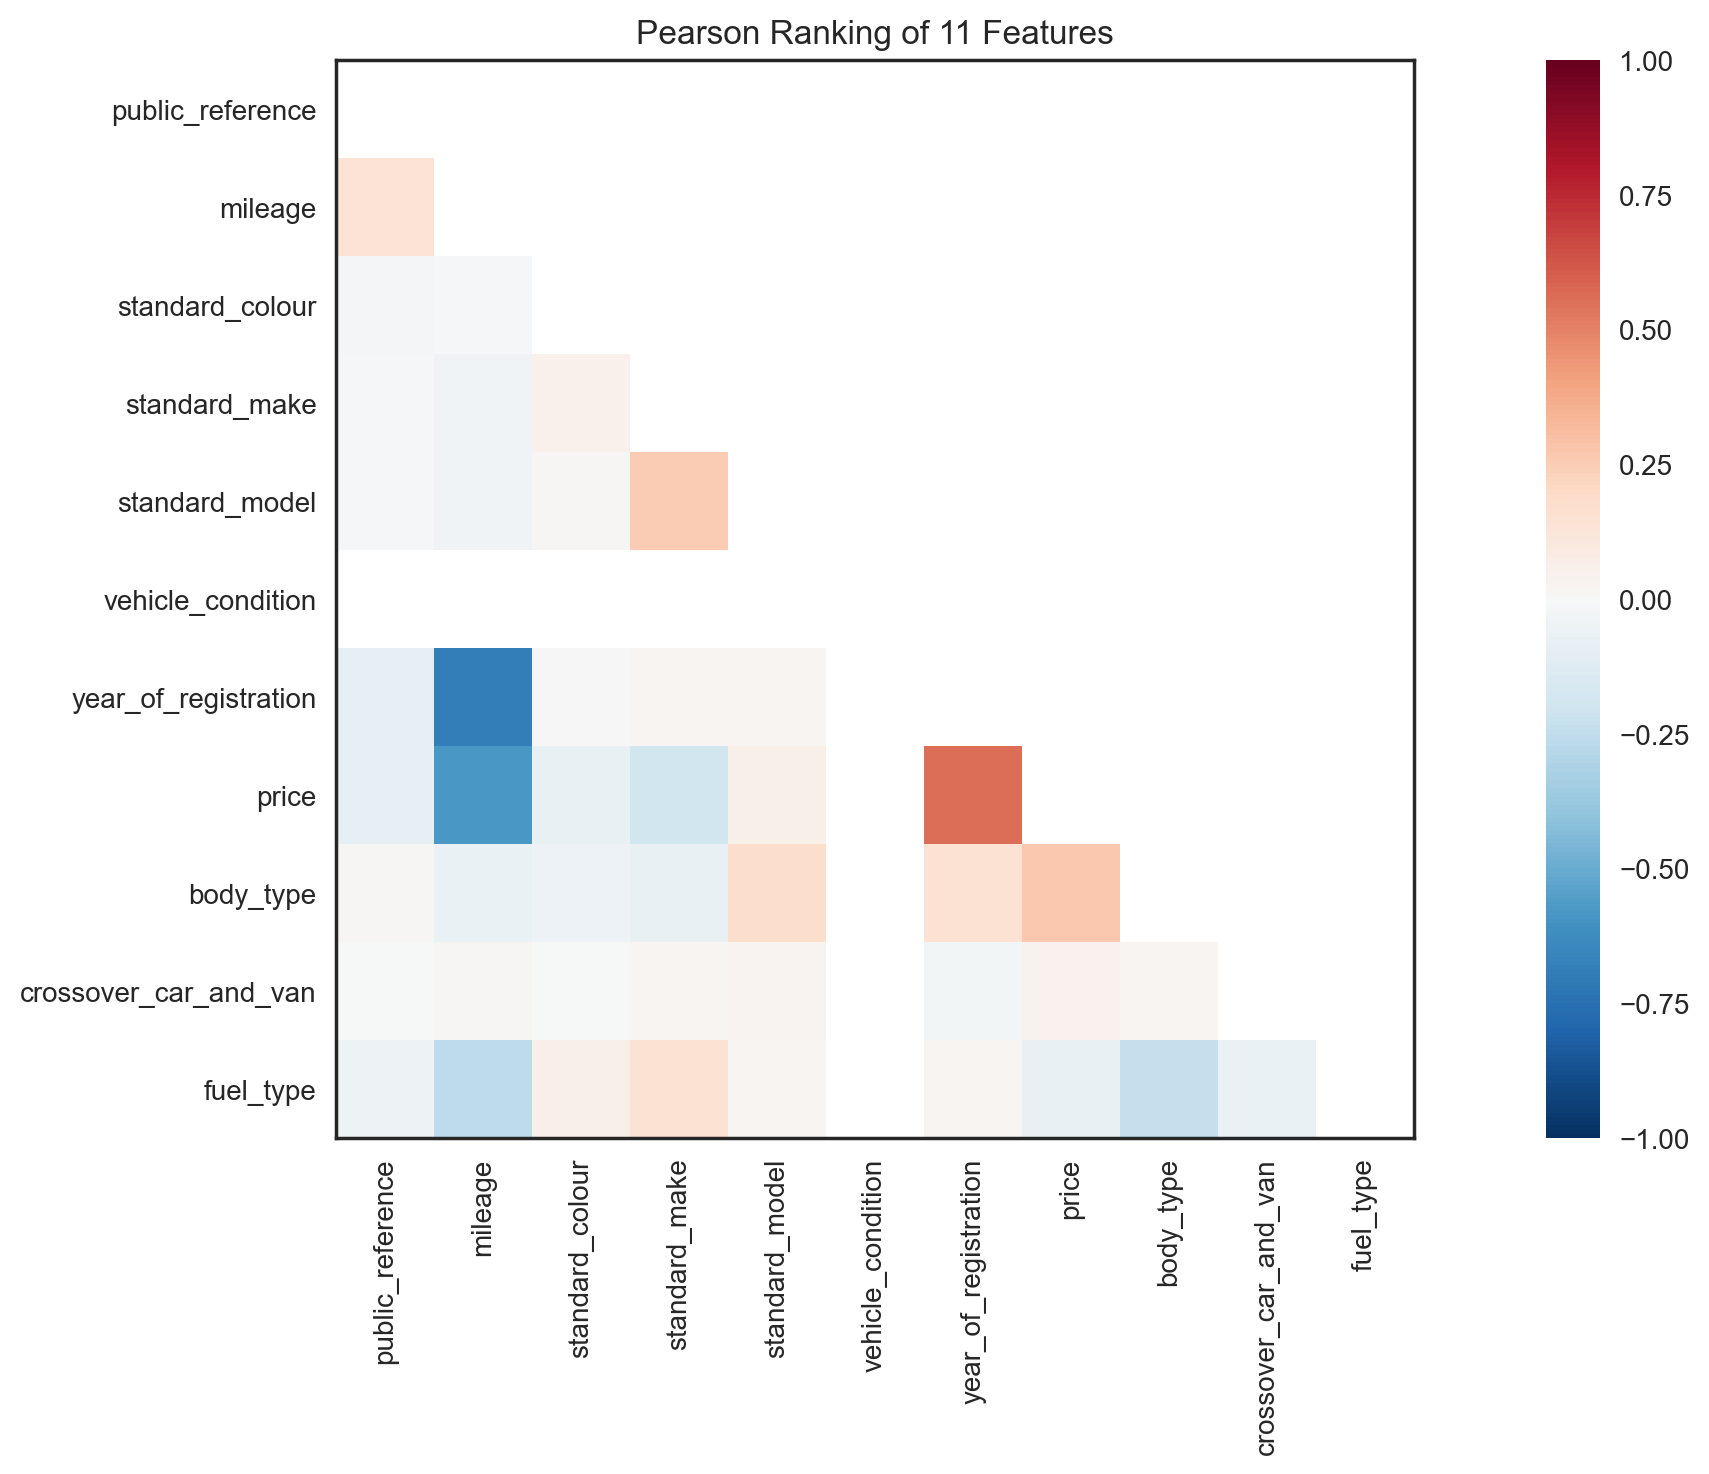

<Axes: title={'center': 'Pearson Ranking of 11 Features'}>

In [34]:
from yellowbrick.features import Rank2D

visualizer = Rank2D(algorithm="pearson")
visualizer.fit_transform(X)
visualizer.show()

In [62]:
from sklearn.preprocessing import MinMaxScaler

X = auto.drop(columns=["reg_code"]).sample(100)
X = X.replace({False:0,True:1,"USED":0,"NEW":1})
X = X.dropna()
X.convert_dtypes()
y = auto.loc[X.index, "price"]
X = pd.DataFrame(OrdinalEncoder().fit_transform(X), columns=X.columns)
X = pd.DataFrame(MinMaxScaler().fit_transform(X), columns=X.columns)